In [9]:
# from IPython.display import Image
from PIL import Image
import pandas as pd

# 1. Concept of mean encoding

##  why does it work?

### mean encoding과 label encoding을 비교해보자.
1. label encoding은 random order. target과 상관관계 X
2. Mean encoding은 0과 1이 분리되도록 도와줌.
3. label encoding보다 더 얕은 depth에서 더 좋은 loss를 보임.

- GBT 모델의 단점 중 하나가 high cardinality categorical feature를 잘 못 다룬다는 것.(tree에는 depth의 limit이 있음)
    - mean encoding으로 약간 좋아지게 할 수 있음.
- 일반적으로 더 복잡하고 target과 비선형적인 feature가 좋은 효과를 보임.

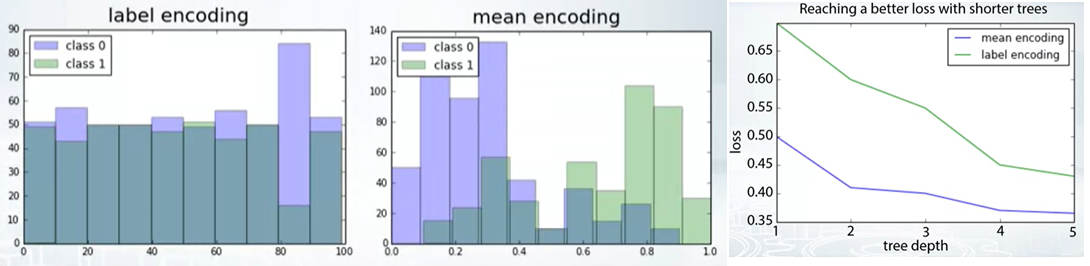

In [10]:
Image.open('img14.png')

mean encoding이 유용한지를 알 수 있는 것.

- depth를 늘렸을 때 training score가 높음
- 그런데 validation score도 높아짐 => not overfit. 이상함
- 이유는 정말 많은 split이 필요한 변수가 있기 때문
- model dump(??)를 통해 확인해보면 어떤 feature에 split point가 엄청 많은 것을 알 수 있음.
    - 바로 이 변수가 중요한 변수라고 할 수 있겠다.

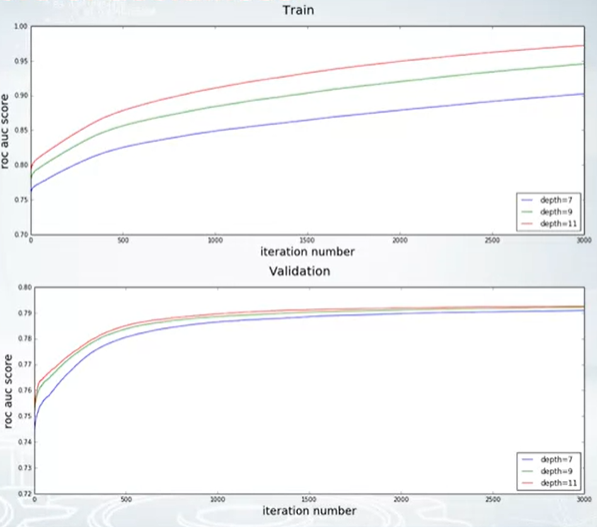

In [11]:
Image.open('img15.png')

## ways to use target variable

- Goods - 1 값
- Bads - 0 값

$$
- Likelihood = \frac{Goods}{Goods + Bads} = mean(target)
$$

$$
- Weight of Evidence = ln(\frac{Goods}{Bads}) * 100
$$

$$
- Count = Goods = sum(target)
$$

$$
- Diff = Goods - Bads
$$

# 2. Regularization
## Overfitting을 피하기 위한 regularization 방법

### step 1. CV loop inside training data
- robust 하고 직관적
- 보통 4~5 fold정도가 괜찮은 결과
- LOO같은 극단적인 상황에서는 data leak 발생할 수 잇음

#### in practice
- stratified Kfold 사용
- category class가 fold에 골고루 안퍼지면 na있을 수 있음. => 그러면 global mean으로 채우자


### step 2. Smoothing
- category가 big, data가 많으면 mean encoding을 충분히 믿을 수 있는데, 만약 그 반대경우면 믿기 어렵다.

$$
\frac{mean(target) * nrows + globalmean * alpha}{nrows + alpha}
$$

- 이렇게 나눌 수 있고

$$
\frac{mean(target) * nrows}{nrows + alpha} + \frac{globalmean * alpha}{nrows + alpha}
$$

- 이렇게 나누면 기존 mean encoding한 값에다가 global mean 값을 약간 첨가
- alpha가 매우 커지면 그냥 global mean이 되고,
- alpha가 0이 되면 그냥 mean encoding
- alpha 값을 우리가 믿을 수 있는 category size라고 생각하면 좋다.
- 다른 regularization이랑 같이 해야함

### step 3. adding random noise
- noise를 줘서 training data에 대한 성능을 낮출 수 있다. 
- 하지만 불안정하고, 잘 work하기 어렵다.
- noise를 얼마나 줘야할지가 어려움. 
    - too much noise => feature into garbage
    - too little noise => worse regularization
    - 보통 LOO regularization과 같이 쓰임. 열심히 fine tuning해야함
    - 시간이 별로 없으면 그닥 좋은 방법은 아님.

### step 4. sorting and calculating expanding mean
- leakage 매우 적음
- hyperparameter tuning 없음
- encoding quality가 불규칙적 => 근데 어차피 여러 모델을 반복해서 ensemble할거니까 상관 없음
- CatBoost에 bulit in.
- categorical feature로 이루어진 데이터에서 매우 좋은 성능

###

cumsum = df_tr.groupby(col)['target'].cumsum() - df_tr['target']

cumcnt = df_tr.groupby(col).cumcount()

train_new[col+'_mean_target'] = cumsum/cumcnt
###

## in practical task
- CV loop
- expanding mean 추천


# 3. Extension and generalizations
## Regression and multi class
### regression
- classification은 mean밖에 할 게 없었는데, regression은 할 수 있는 것이 많다.
    - median, percentile, std, distribution bins.
        - distribution bins : 만약 target이 1~100이라고 하자. 첫번째 feature는 1~10사이에 데이터가 몇개나 있는 지. 그다음은 10~20, 등등
        - 물론 regularization 필수.
        
**요약하면 regression은 classification이랑 비슷하지만, 다양하다.**

### multi class
- 간단하게 n개의 class가 있으면 각 class에 대해 mean encoding하면 됨. => non obvious advantage
    - tree model로 예를 들면, multiclass 문제를 풀때, 각 클래스에 대해 binary 로 생각하고 각각 문제를 푼다. 
    - 그러니까 모든 class에 대해 다른 모델이 있는 것. 그리고 그 모델에 fit할 때, 다른 class에 대한 정보를 하나도 갖고 있지 않다. 
    - 왜냐면 하나로 합쳐져있으니까(다른 class는 하나로 합쳐져 있으니까). 그래서 위와 같은 encoding을 해주면 다른 class에 대한 추가적인 정보를 줄 수 있다.

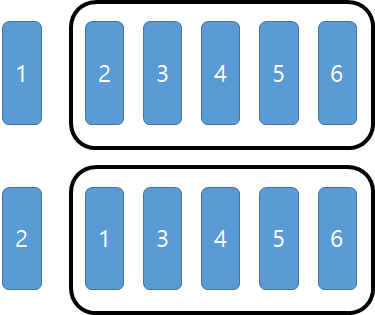

In [12]:
Image.open('img16.png')

### many-to-many relations
- cross product of entities
- Statistics from vectors

**why many-to-many relations?**
- 각 user는 여러개의 app을 사용
- 각 app은 여러명의 유저가 사용

apps라는 feature로 mean encoding을 해보고 싶다. 
- 원래 df에서 long representation 형태로 바꿔준다. user-app pair row 생성
- 이렇게 만들어서 mean encoding할 수 있다.
*user에 join은 어떻게?*
- 각 user는 여러 앱을 가지고 있음
- APP1, APP2, APP3 말고, [0.1,0.2,0.1] 이렇게 벡터로 만들 수 있음.(mean encoding한 결과 값)
- 그 다음에 이 벡터로 min, max, mean, median, std 등등 마니하셈.


In [13]:
print('원래 DF')
pd.DataFrame({'User_id' : [10,11,12,100],
             'APPS' : ['APP1;APP2;APP3','APP4;APP1','APP2','APP3;APP9'],
              'Target' : [0,1,1,0]})

원래 DF


,User_id,APPS,Target
0,10,APP1;APP2;APP3,0
1,11,APP4;APP1,1
2,12,APP2,1
3,100,APP3;APP9,0


In [14]:
print('Long representation')
pd.DataFrame({'User_id' : [10,10,10,11,11],
             'APP_id' : ['APP1','APP2','APP3','APP4','APP1'],
             'Target' : [0,0,0,1,1]})

Long representation


,User_id,APP_id,Target
0,10,APP1,0
1,10,APP2,0
2,10,APP3,0
3,11,APP4,1
4,11,APP1,1


## Time series

In [15]:
pd.DataFrame({'Day' : [1,1,1,2,2,2],
             'User' : [101,101,102,101,101,102],
             'Spend' : ['FOOD','GAS','FOOD','GAS','TV','FOOD'],
             'Amount' : [2.0,4.0,3.0,4.0,8.0,2.0]})

,Day,User,Spend,Amount
0,1,101,FOOD,2.0
1,1,101,GAS,4.0
2,1,102,FOOD,3.0
3,2,101,GAS,4.0
4,2,101,TV,8.0
5,2,102,FOOD,2.0


가령 이런 df에서 
- category 를 3일 이내에 산사람. 
- category 에 대해 3일 이내에 결제 액.

**time 요소를 가미하여 more complicated feature 생성 가능**

## interactions and numerical features
### numerical feature
numerical feature 는 bin을 나누어 categorical로 바꾸어줄 수 있다.


- how to bin numeric feature

- how to select useful combination of features


걍 메모
아무 encoding도 안한 상태로 xgboost를 돌렸다 치자. 어떤 feature에 대해서 엄청나게 많이 split이 되었다 라고 하면, 그 변수는 target과 복잡한 어떤 관계가 있다는 것. 그럼 얘를 mean encoding 할 가치가 잇음. 글고 딱 이 split points 가 feature bin 이 될 수도 있지. 뭔가 의심스러운 feature를 찾아내고, 그걸 bin할 수 있는 좋은 방법을 찾아내자. 

tree 에서 두개의 이웃하는 node는 두 feature가 interact 하고 있다. 몇번이나 그 interaction이 등장했는지 셀 수 있다. 가장 많이 interaction이 있는 변수가 mean encoding 하기에 좋다. 

그림처럼 feature1이랑 feature2랑 pair가 가장 자주 등장했다면, 두개의 feature를 concat해서 mean encoding하자. 

# 4. Correct validation reminder
- Local experiments:
    - X_tr로 estimate encoding
    - X_tr, X_val에 map
    - regularize on X_tr
    - validate model on X_tr / X_val split
**data split하기 전에 estimate encoding 절대 놉**

- Submission
    - Train 전체 data에다가 estimate encoding
    - Train이랑 Test에 map
    - regularize on train
    - fit on train
**regularization method는 local experiment에서 이미 결정해놔야함**

# 5. advantage / disadvantage of mean encoding
- main advantages :
    - compact transformation of categorical 변수
    - powerful basis for FE.
    
- disadvantage
    - target data leakage. validation과 regularization에 신경을 많이 써라.
    - 모든 대회에서 다 도움이 되는 것은 아님. 특정 데이터에서는 좋음.